<a href="https://colab.research.google.com/github/Deleon57/EDAR-REGRESSION/blob/main/Pipeline2(GFI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [28]:
data1 = pd.read_csv("GFI_dataset.csv")

# Convert Date column to datetime
data1['Date'] = pd.to_datetime(data1['Date'])
data1 = data1.sort_values('Date')
data1.set_index('Date', inplace=True)

print(data1.head())

                  Close         High          Low         Open
Date                                                          
2012-12-31  9091.963867  9151.554951  8999.072886  9104.232763
2013-01-01  9091.963867  9091.963867  9091.963867  9091.963867
2013-01-02  9323.318359  9325.946504  9043.767691  9151.556707
2013-01-03  9335.583984  9376.772209  9183.978625  9289.138496
2013-01-04  9049.024414  9131.399905  8955.256723  9113.873744


/tmp/ipython-input-4064079063.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data1['Date'] = pd.to_datetime(data1['Date'])


In [29]:
from statsmodels.tsa.stattools import adfuller

# Loop through each feature
for col in ["Close", "High", "Low", "Open"]:
    result = adfuller(data1[col].dropna())
    print(f"Feature: {col}")
    print("  ADF Statistic:", result[0])
    print("  p-value:", result[1])
    print("-" * 40)

Feature: Close
  ADF Statistic: -0.8927524476821448
  p-value: 0.790349769845352
----------------------------------------
Feature: High
  ADF Statistic: -1.129604601213029
  p-value: 0.7031227284341343
----------------------------------------
Feature: Low
  ADF Statistic: -1.0113363349123317
  p-value: 0.7491072102344439
----------------------------------------
Feature: Open
  ADF Statistic: -1.0917706683810122
  p-value: 0.7183424850696943
----------------------------------------


In [30]:
# Define the ADF test function
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('-'*50)

features = data1.select_dtypes(include=[np.number]).columns

# Calculate percentage change (returns)
data_returns = data1[features].pct_change().dropna()

# Run ADF test on each feature
for col in features:
    adf_test(data_returns[col], title=f"{col} (Returns)")

Augmented Dickey-Fuller Test: Close (Returns)
ADF Statistic: -40.17952119272028
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: High (Returns)
ADF Statistic: -39.88932325419743
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: Low (Returns)
ADF Statistic: -13.49927808718864
p-value: 2.9990343346863835e-25
--------------------------------------------------
Augmented Dickey-Fuller Test: Open (Returns)
ADF Statistic: -18.951097277075363
p-value: 0.0
--------------------------------------------------


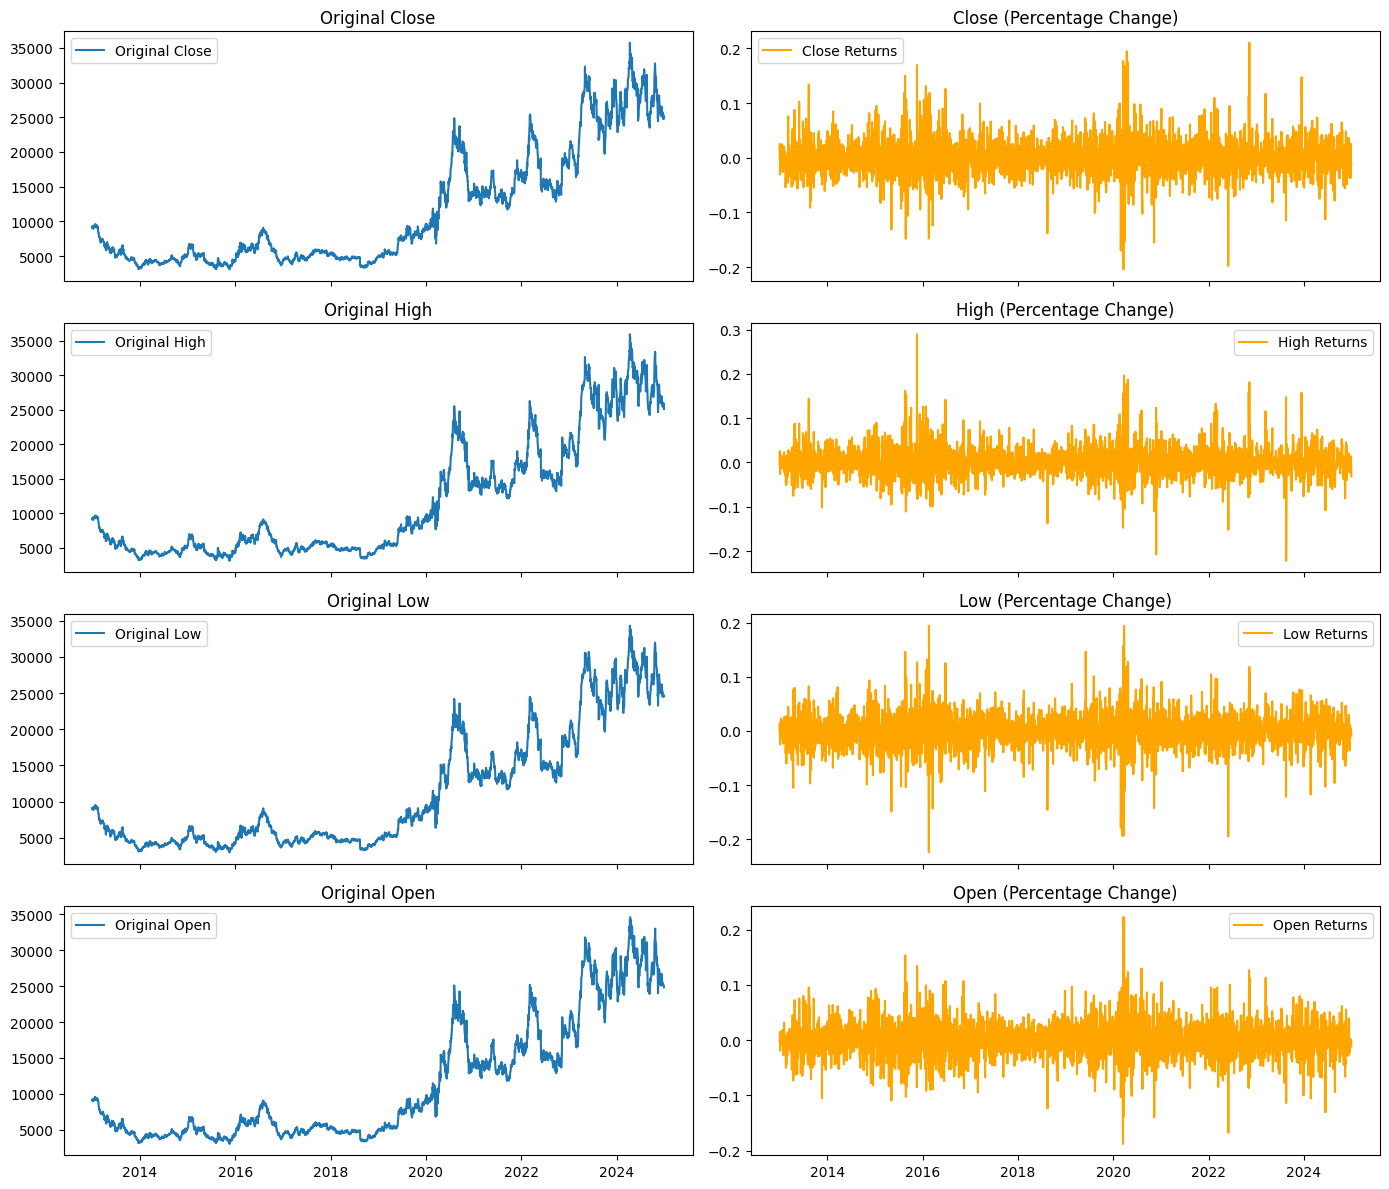

In [31]:
n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(14, 3*n_features), sharex=True)

for i, col in enumerate(features):

    axes[i,0].plot(data1[col], label=f"Original {col}")
    axes[i,0].set_title(f"Original {col}")
    axes[i,0].legend()

    axes[i,1].plot(data_returns[col], label=f"{col} Returns", color='orange')
    axes[i,1].set_title(f"{col} (Percentage Change)")
    axes[i,1].legend()

plt.tight_layout()
plt.show()

In [32]:
train = data_returns[data_returns.index < "2023-01-01"]
test  = data_returns[data_returns.index >= "2023-01-01"]

# Features (X) and Target (y)
X_train = train[["High", "Low", "Open"]]
y_train = train["Close"]

X_test = test[["High", "Low", "Open"]]
y_test = test["Close"]

print("Before scaling:")
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nAfter scaling:")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

Before scaling:
Train shape: (2551, 3) (2551,)
Test shape: (497, 3) (497,)

After scaling:
X_train_scaled shape: (2551, 3)
X_test_scaled shape: (497, 3)


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Scale Features (X) and Target (y)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Scale X
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Scale y (reshape to 2D before scaling, then flatten back)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1)).ravel()

svr = SVR(kernel='rbf', C=10, gamma=0.01, epsilon=0.01)
svr.fit(X_train_scaled, y_train_scaled)

# Predict on test set
y_pred_scaled = svr.predict(X_test_scaled)

# Inverse transform predictions back to original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

In [34]:
# KNN Model

knn = KNeighborsRegressor(n_neighbors=5)  # you can tune n_neighbors later
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)


In [35]:
# Support Vector Regressor (SVR) Model

svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)  # you can tune hyperparameters later
svr.fit(X_train_scaled, y_train_scaled)

y_pred_scaled = svr.predict(X_test_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()


In [36]:
# Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [37]:
# XGBoost Regression Model

# Initialise and fit model
xgb = XGBRegressor(n_estimators=100, random_state=42)  # you can tune hyperparameters later
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [43]:
# Helper function for metrics

def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = (100/len(y_true)) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )
    r2 = r2_score(y_true, y_pred)

    return {
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE%": mape,
        "SMAPE%": smape,
        "R²": r2
    }

# Train and evaluate models

results = []

# 1. KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
results.append(evaluate_model(y_test, y_pred, "KNN"))

# 2. SVR (assumes scaling already done: X_train_scaled, X_test_scaled, y_scaler)
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train_scaled, y_train_scaled)
y_pred_scaled = svr.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
results.append(evaluate_model(y_test, y_pred, "SVR"))

# 3. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
results.append(evaluate_model(y_test, y_pred, "Random Forest"))

# 4. XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
results.append(evaluate_model(y_test, y_pred, "XGBoost"))

results_df = pd.DataFrame(results)
display(results_df)


,Model,RMSE,MAE,MAPE%,SMAPE%,R²
0,KNN,0.016815,0.012291,173.031343,93.633567,0.640732
1,SVR,0.015413,0.011377,176.732016,90.327047,0.698155
2,Random Forest,0.017814,0.012194,173.439139,91.439773,0.596760
3,XGBoost,0.019288,0.013302,209.965748,95.083838,0.527282


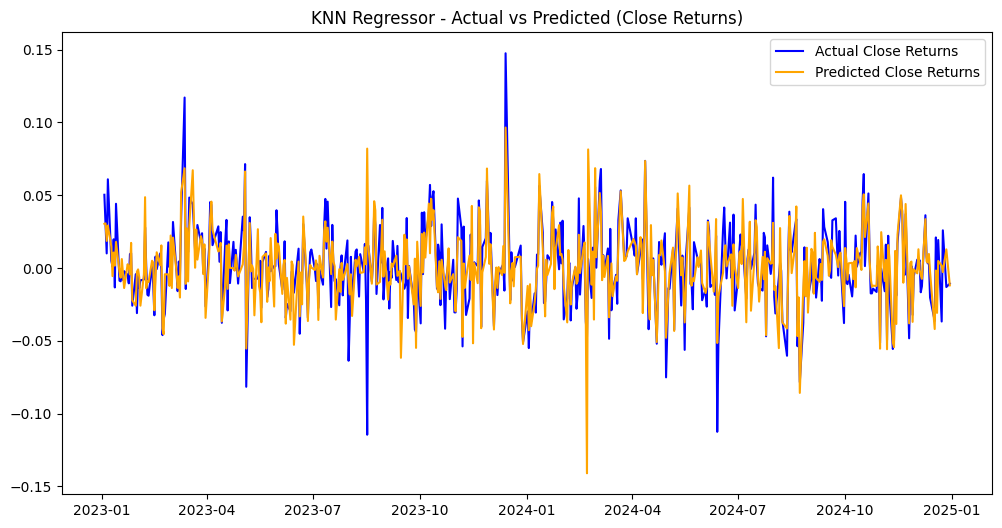

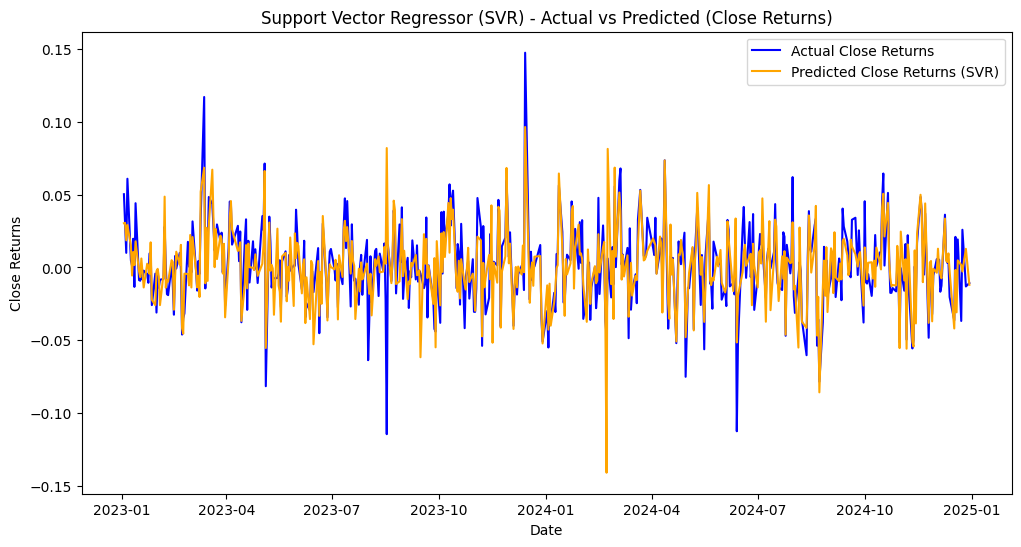

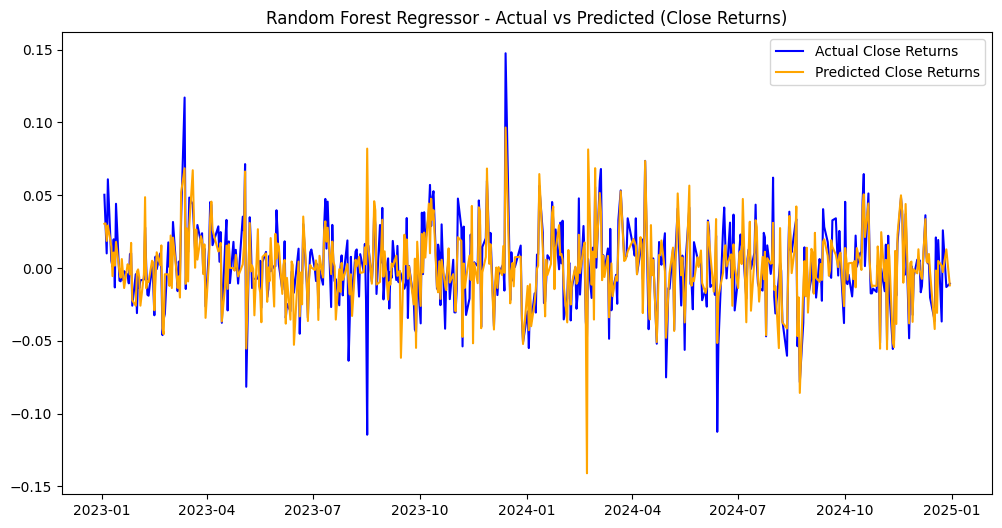

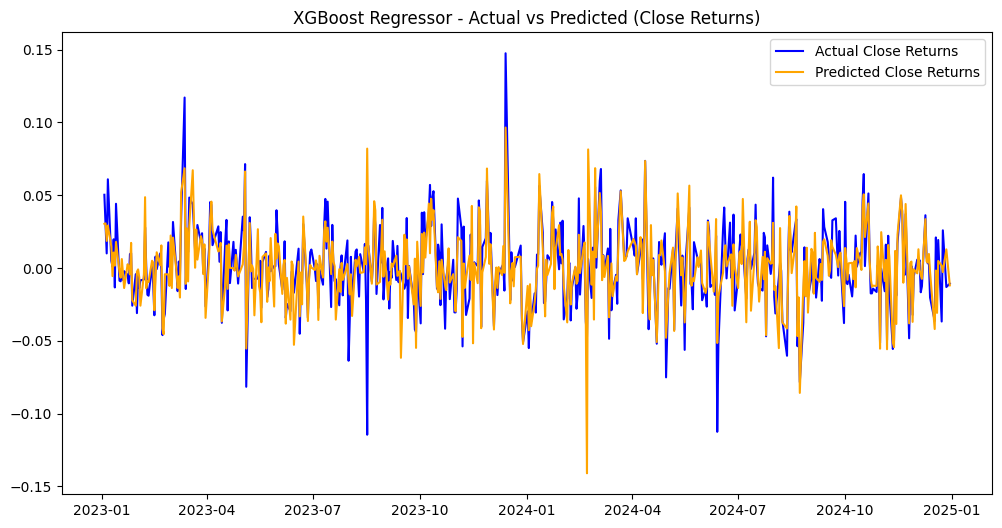

In [44]:
# ===============================
# Visualise Actual vs Predicted
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual Close Returns", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Close Returns", color="orange")
plt.title("KNN Regressor - Actual vs Predicted (Close Returns)")
plt.legend()
plt.show()

# ==============================
# Visualise Actual vs Predicted
# ==============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual Close Returns", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Close Returns (SVR)", color="orange")

plt.title("Support Vector Regressor (SVR) - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual Close Returns", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Close Returns", color="orange")
plt.title("Random Forest Regressor - Actual vs Predicted (Close Returns)")
plt.legend()
plt.show()

# ==============================
# Visualise Actual vs Predicted
# ==============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual Close Returns", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Close Returns", color="orange")
plt.title("XGBoost Regressor - Actual vs Predicted (Close Returns)")
plt.legend()
plt.show()

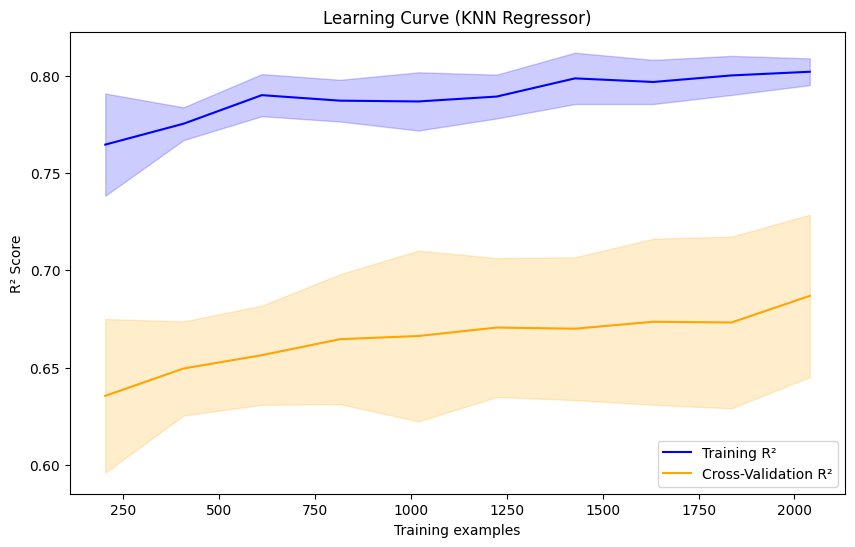

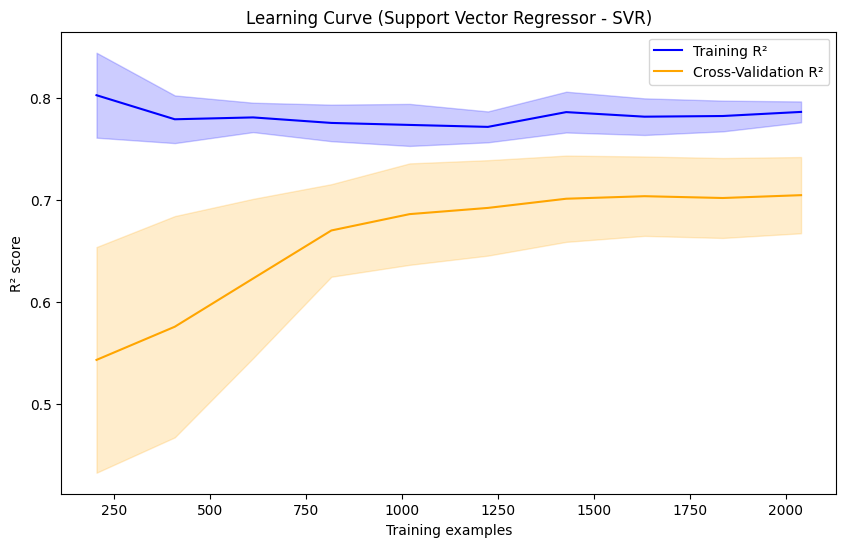

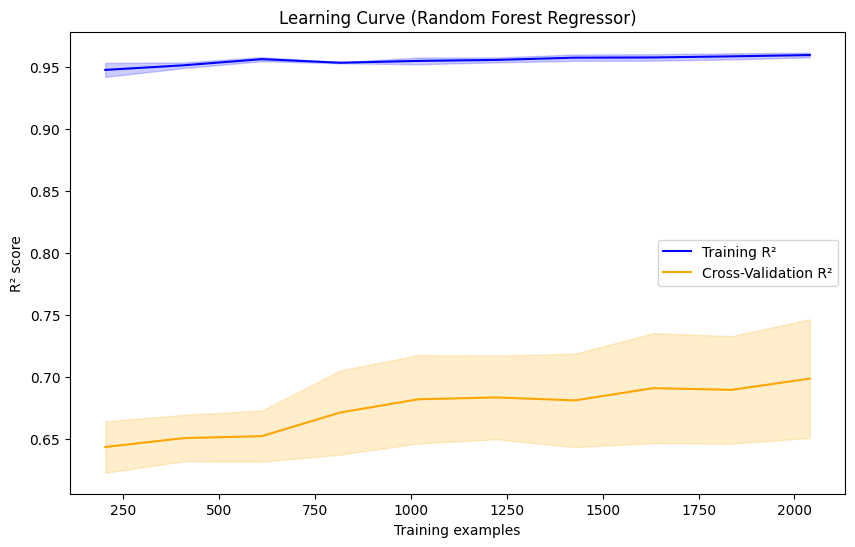

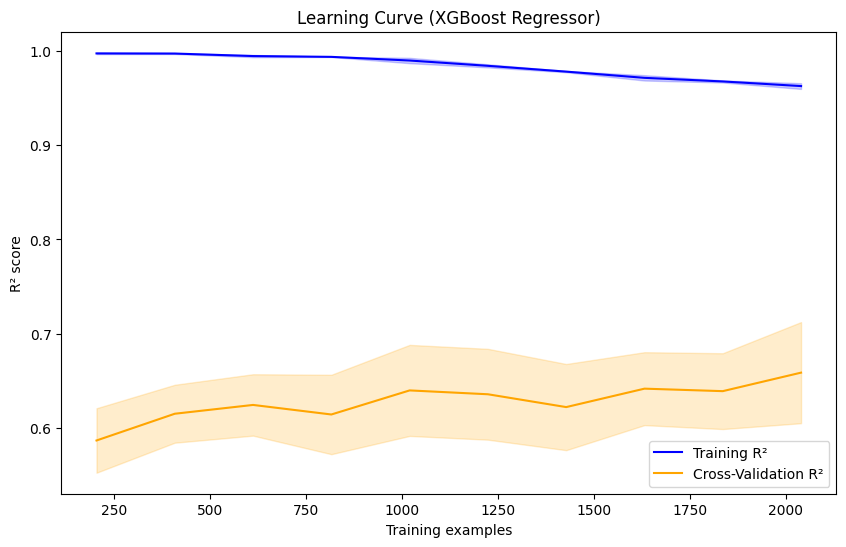

In [45]:
#KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)  # you can tune this later

train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_model,
    X=X_train,
    y=y_train,
    cv=5,                   # 5-fold cross validation
    scoring="r2",           # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (KNN Regressor)")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.show()

# SVR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR

# ==============================
# Define SVR model
# ==============================
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

# ==============================
# Generate learning curve (use scaled data)
# ==============================
train_sizes, train_scores, test_scores = learning_curve(
    estimator=svr_model,
    X=X_train_scaled,   # use scaled X
    y=y_train_scaled,   # use scaled y
    cv=5,               # 5-fold cross validation
    scoring="r2",       # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# ==============================
# Calculate mean and std
# ==============================
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# ==============================
# Plot Learning Curve
# ==============================
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (Support Vector Regressor - SVR)")
plt.xlabel("Training examples")
plt.ylabel("R² score")
plt.legend(loc="best")
plt.show()

# RF
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model,
    X=X_train,
    y=y_train,
    cv=5,                     # 5-fold cross validation
    scoring="r2",             # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (Random Forest Regressor)")
plt.xlabel("Training examples")
plt.ylabel("R² score")
plt.legend(loc="best")
plt.show()

#XGBoost
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor

# ==============================
# Define XGBoost model
# ==============================
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# ==============================
# Generate learning curve
# ==============================
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_model,
    X=X_train,
    y=y_train,
    cv=5,                         # 5-fold cross validation
    scoring="r2",                 # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# ==============================
# Calculate mean and std
# ==============================
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# ==============================
# Plot Learning Curve
# ==============================
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (XGBoost Regressor)")
plt.xlabel("Training examples")
plt.ylabel("R² score")
plt.legend(loc="best")
plt.show()


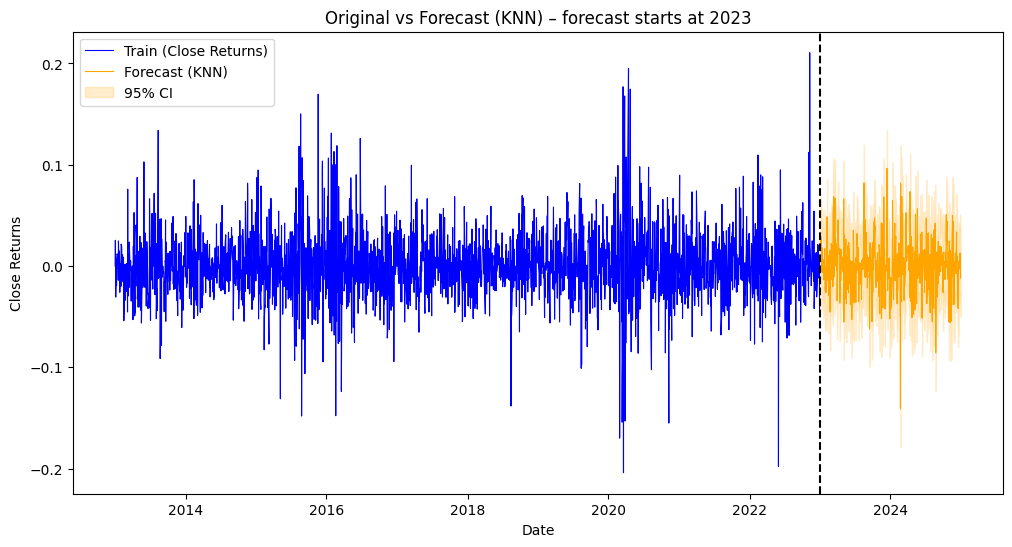

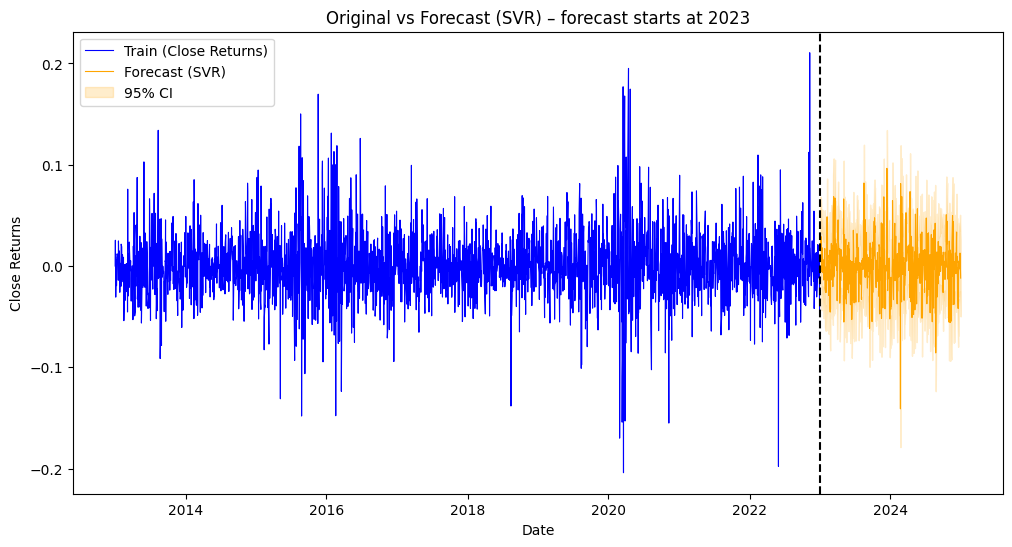

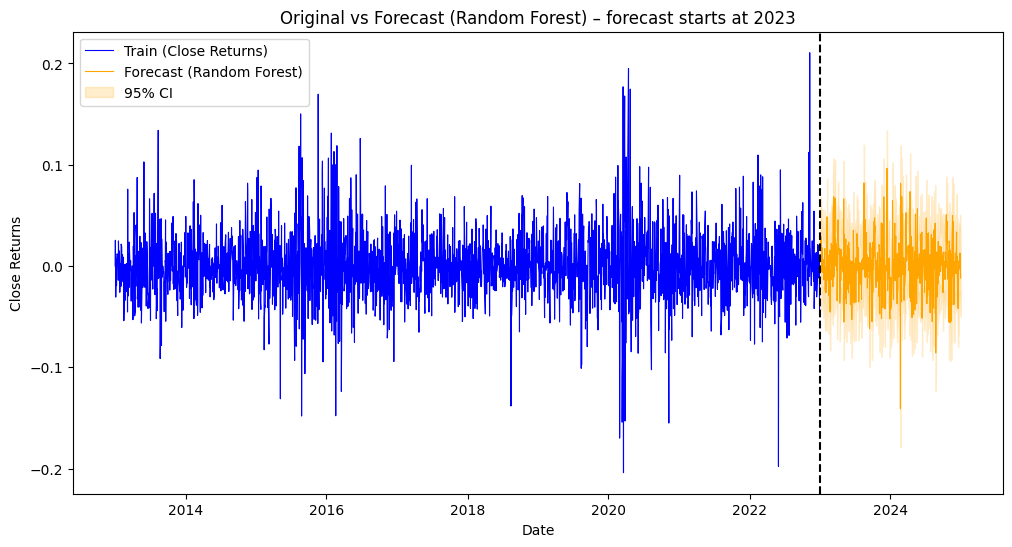

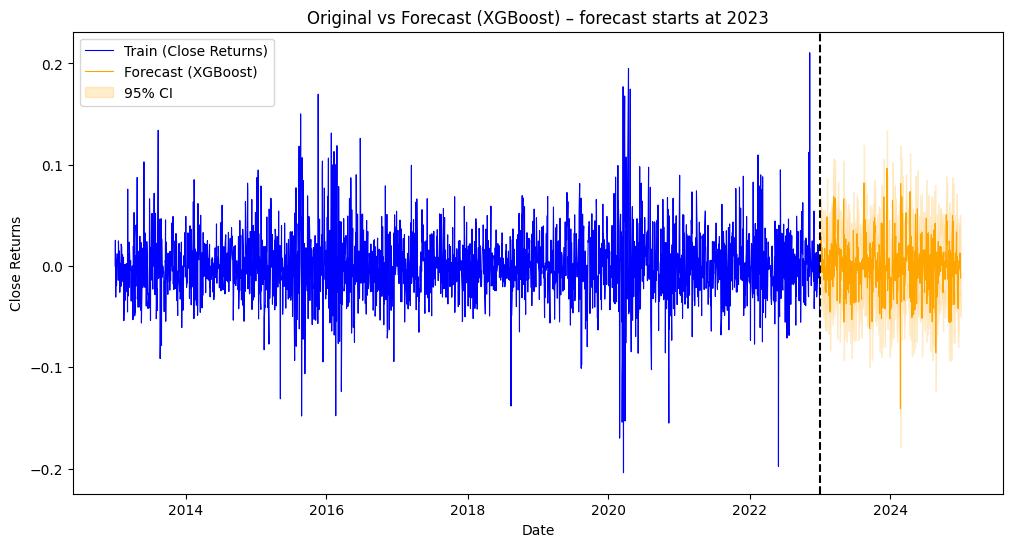

In [48]:
#KNN
# Error and confidence interval
error = y_test.values - y_pred
err_std = np.std(error)
lower = y_pred - 1.96 * err_std
upper = y_pred + 1.96 * err_std

plt.figure(figsize=(12,6))

# Training data (blue) – use actual index
plt.plot(y_train.index, y_train.values, label="Train (Close Returns)", color="blue", linewidth=0.8)

# Forecast (orange) – align with test index
plt.plot(y_test.index, y_pred, label="Forecast (KNN)", color="orange", linewidth=0.8)

# Confidence Interval
plt.fill_between(y_test.index, lower, upper, color="orange", alpha=0.2, label="95% CI")

# Vertical line at boundary
plt.axvline(x=y_test.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (KNN) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


#SVR
# Error and confidence interval (make sure y_pred is inverse transformed)
error = y_test.values - y_pred
err_std = np.std(error)
lower = y_pred - 1.96 * err_std
upper = y_pred + 1.96 * err_std

plt.figure(figsize=(12,6))

# Training data (blue) – use actual index
plt.plot(y_train.index, y_train.values, label="Train (Close Returns)", color="blue", linewidth=0.8)

# Forecast (orange) – align with test index
plt.plot(y_test.index, y_pred, label="Forecast (SVR)", color="orange", linewidth=0.8)

# Confidence Interval
plt.fill_between(y_test.index, lower, upper, color="orange", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (SVR) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

#RF
error = y_test.values - y_pred
err_std = np.std(error)
lower = y_pred - 1.96 * err_std
upper = y_pred + 1.96 * err_std

plt.figure(figsize=(12,6))

# Training data (blue) – use actual index
plt.plot(y_train.index, y_train.values, label="Train (Close Returns)", color="blue", linewidth=0.8)

# Forecast (orange) – align with test index
plt.plot(y_test.index, y_pred, label="Forecast (Random Forest)", color="orange", linewidth=0.8)

plt.fill_between(y_test.index, lower, upper, color="orange", alpha=0.2, label="95% CI")

plt.axvline(x=y_test.index[0], color="k", linestyle="--")

plt.title("Original vs Forecast (Random Forest) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

#XGBOOST
# Error and confidence interval
error = y_test.values - y_pred
err_std = np.std(error)
lower = y_pred - 1.96 * err_std
upper = y_pred + 1.96 * err_std

plt.figure(figsize=(12,6))

# Training data (blue) - use actual index
plt.plot(y_train.index, y_train.values, label="Train (Close Returns)", color="blue", linewidth=0.8)

# Forecast (orange) - align with test index
plt.plot(y_test.index, y_pred, label="Forecast (XGBoost)", color="orange", linewidth=0.8)

# Confidence Interval
plt.fill_between(y_test.index, lower, upper, color="orange", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (XGBoost) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

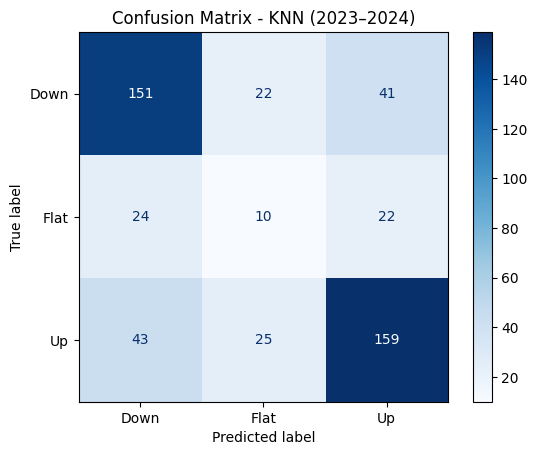

Classification Report - KNN
              precision    recall  f1-score   support

        Down       0.69      0.71      0.70       214
        Flat       0.18      0.18      0.18        56
          Up       0.72      0.70      0.71       227

    accuracy                           0.64       497
   macro avg       0.53      0.53      0.53       497
weighted avg       0.65      0.64      0.64       497



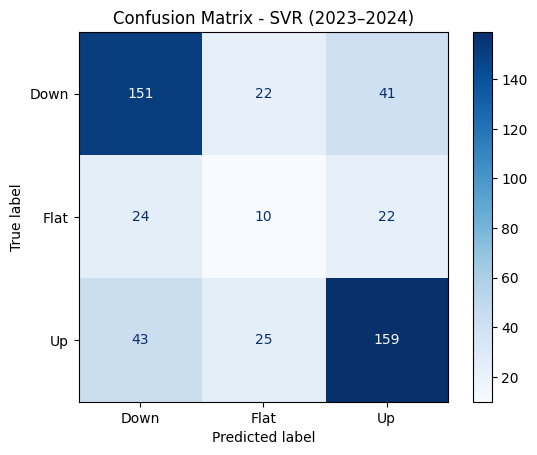

Classification Report - SVR
              precision    recall  f1-score   support

        Down       0.69      0.71      0.70       214
        Flat       0.18      0.18      0.18        56
          Up       0.72      0.70      0.71       227

    accuracy                           0.64       497
   macro avg       0.53      0.53      0.53       497
weighted avg       0.65      0.64      0.64       497



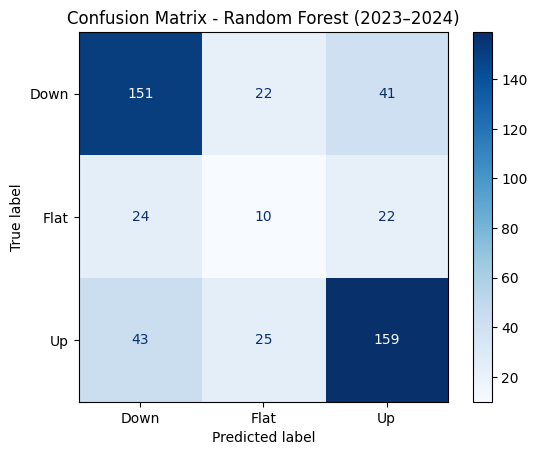

Classification Report - Random Forest
              precision    recall  f1-score   support

        Down       0.69      0.71      0.70       214
        Flat       0.18      0.18      0.18        56
          Up       0.72      0.70      0.71       227

    accuracy                           0.64       497
   macro avg       0.53      0.53      0.53       497
weighted avg       0.65      0.64      0.64       497



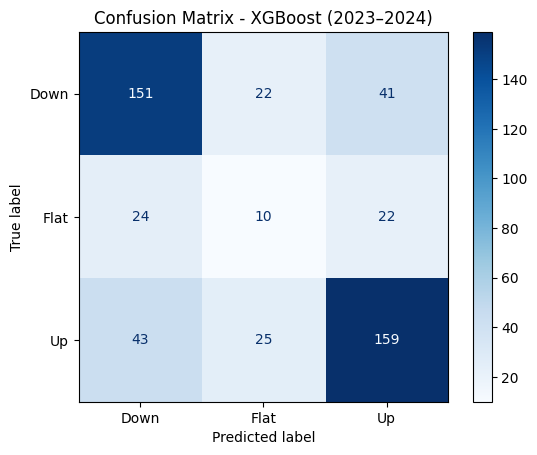

Classification Report - XGBoost
              precision    recall  f1-score   support

        Down       0.69      0.71      0.70       214
        Flat       0.18      0.18      0.18        56
          Up       0.72      0.70      0.71       227

    accuracy                           0.64       497
   macro avg       0.53      0.53      0.53       497
weighted avg       0.65      0.64      0.64       497



In [50]:
#KNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ensure arrays ---
y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()

# --- 2. Convert regression outputs into classes ---
def to_class(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = up, -1 = down, 0 = flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)   # threshold based on std deviation

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1           # Up
    cls[delta < -eps] = -1         # Down
    return cls

# --- 3. Compute daily differences ---
delta_true = np.diff(y_test_arr, prepend=y_test_arr[0])
delta_pred = np.diff(y_pred_arr, prepend=y_pred_arr[0])

# --- 4. Convert differences to classes ---
true_cls = to_class(delta_true)
pred_cls = to_class(delta_pred)

# --- 5. Confusion Matrix ---
labels = [-1, 0, 1]  # Down, Flat, Up
cm = confusion_matrix(true_cls, pred_cls, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Flat", "Up"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - KNN (2023–2024)")
plt.show()

# --- 6. Classification Report ---
print("Classification Report - KNN")
print(classification_report(true_cls, pred_cls, target_names=["Down", "Flat", "Up"]))


#SVM
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ensure arrays ---
y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()

# --- 2. Convert regression outputs into classes ---
def to_class(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)  # threshold based on std deviation

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

# --- 3. Compute daily differences ---
delta_true = np.diff(y_test_arr, prepend=y_test_arr[0])
delta_pred = np.diff(y_pred_arr, prepend=y_pred_arr[0])

# --- 4. Convert differences to classes ---
true_cls = to_class(delta_true)
pred_cls = to_class(delta_pred)

# --- 5. Confusion Matrix ---
labels = [-1, 0, 1]  # Down, Flat, Up
cm = confusion_matrix(true_cls, pred_cls, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Flat", "Up"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - SVR (2023–2024)")
plt.show()

# --- 6. Classification Report ---
print("Classification Report - SVR")
print(classification_report(true_cls, pred_cls, target_names=["Down", "Flat", "Up"]))

#RF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()

def to_class(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1          # Up
    cls[delta < -eps] = -1        # Down
    return cls

delta_true = np.diff(y_test_arr, prepend=y_test_arr[0])
delta_pred = np.diff(y_pred_arr, prepend=y_pred_arr[0])

true_cls = to_class(delta_true)
pred_cls = to_class(delta_pred)

labels = [-1, 0, 1]  # Down, Flat, Up
cm = confusion_matrix(true_cls, pred_cls, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Flat", "Up"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest (2023–2024)")
plt.show()

print("Classification Report - Random Forest")
print(classification_report(true_cls, pred_cls, target_names=["Down", "Flat", "Up"]))

#XGBOOST
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ensure arrays ---
y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()

# --- 2. Convert regression outputs into classes ---
def to_class(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)   # threshold based on std deviation

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

# --- 3. Compute daily differences ---
delta_true = np.diff(y_test_arr, prepend=y_test_arr[0])
delta_pred = np.diff(y_pred_arr, prepend=y_pred_arr[0])

# --- 4. Convert differences to classes ---
true_cls = to_class(delta_true)
pred_cls = to_class(delta_pred)

# --- 5. Confusion Matrix ---
labels = [-1, 0, 1]  # Down, Flat, Up
cm = confusion_matrix(true_cls, pred_cls, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Flat", "Up"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - XGBoost (2023–2024)")
plt.show()

# --- 6. Classification Report ---
print("Classification Report - XGBoost")
print(classification_report(true_cls, pred_cls, target_names=["Down", "Flat", "Up"]))



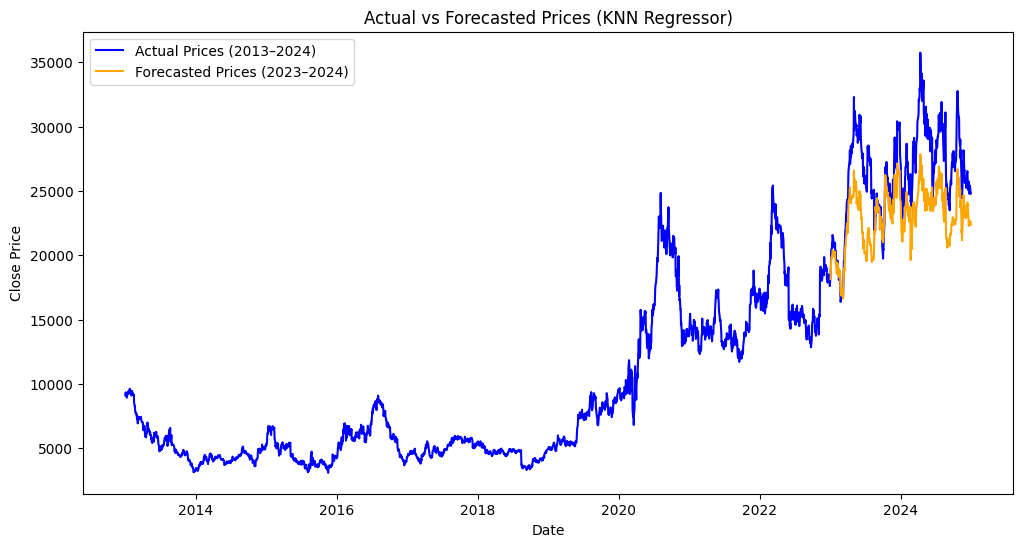

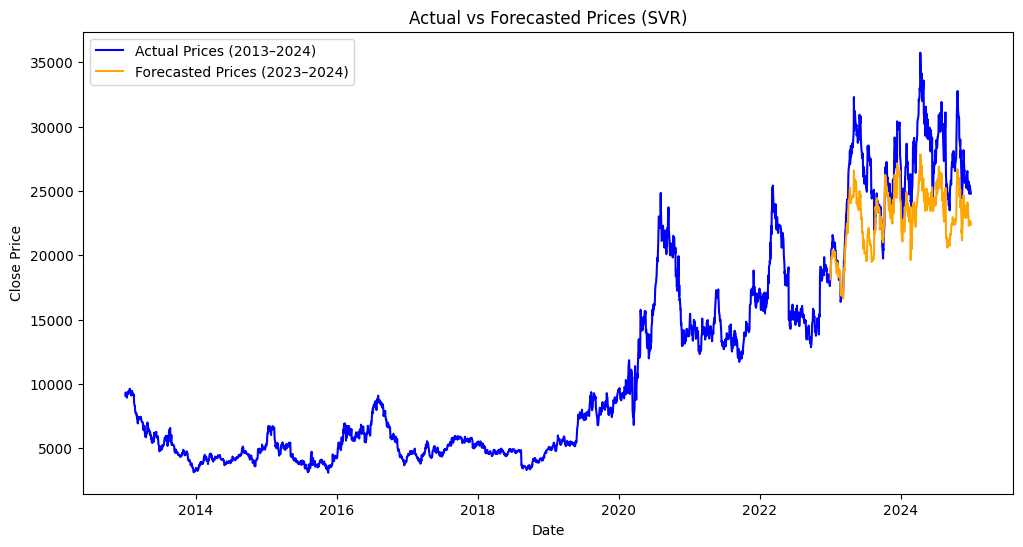

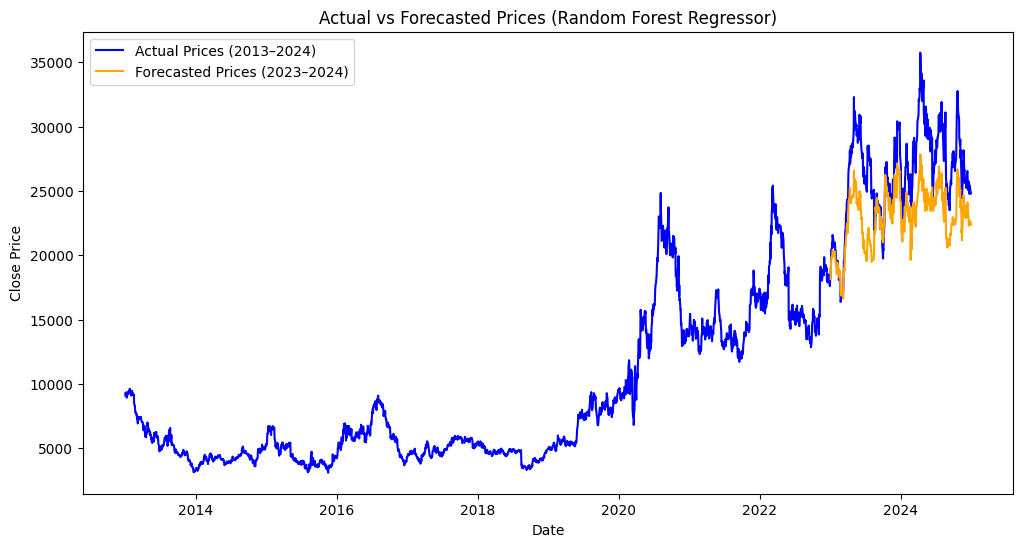

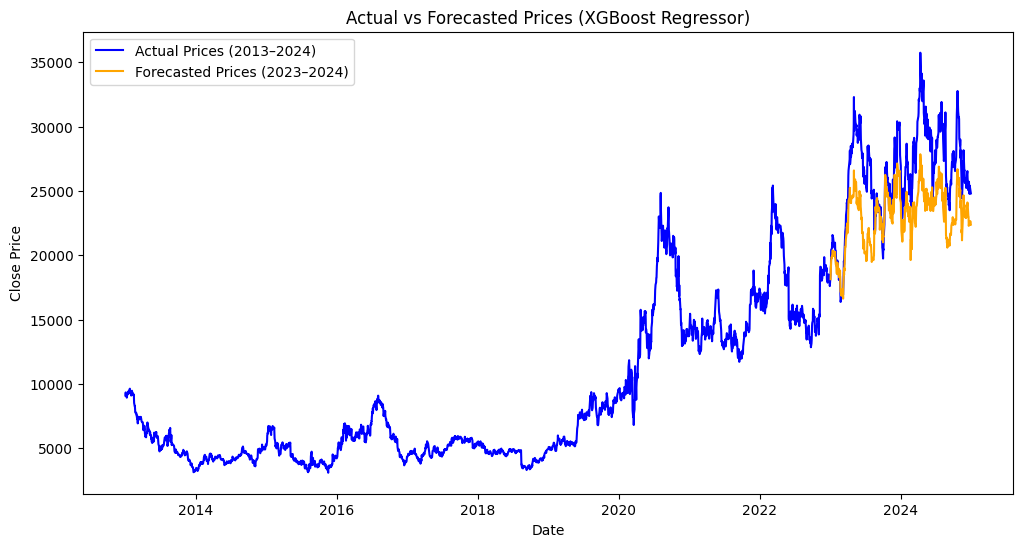

In [51]:
#KNN
# ===============================
# 1. Reconstruct ACTUAL prices from returns (2013–2024)
# ===============================

# Start from the first actual price in 2013
P0 = data1["Close"].iloc[0]

# Rebuild prices from returns
reconstructed_prices = (1 + data_returns["Close"]).cumprod() * P0

# ===============================
# 2. Reconstruct FORECASTED prices from returns (2023–2024)
# ===============================

# Start from the last actual price before forecast period (end of 2022)
last_price_2022 = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]

# Convert forecasted returns (y_pred) into price levels
forecast_prices = (1 + pd.Series(y_pred, index=y_test.index)).cumprod() * last_price_2022

# ===============================
# 3. Plot Actual vs Forecasted
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot actual reconstructed prices
plt.plot(reconstructed_prices.index, reconstructed_prices, label="Actual Prices (2013–2024)", color="blue")

# Plot forecasted prices
plt.plot(forecast_prices.index, forecast_prices, label="Forecasted Prices (2023–2024)", color="orange")

plt.title("Actual vs Forecasted Prices (KNN Regressor)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#SVR
# ==============================
# 1. Reconstruct ACTUAL prices from returns (2013–2024)
# ==============================
p0 = data1["Close"].iloc[0]  # first actual price in 2013
reconstructed_prices = (1 + data_returns["Close"]).cumprod() * p0

# ==============================
# 2. Reconstruct FORECASTED prices from returns (2023–2024)
# ==============================
last_price_2022 = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]  # last actual before forecast

forecast_prices = (1 + pd.Series(y_pred, index=y_test.index)).cumprod() * last_price_2022

# ==============================
# 3. Plot Actual vs Forecasted
# ==============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Actual reconstructed prices
plt.plot(reconstructed_prices.index, reconstructed_prices,
         label="Actual Prices (2013–2024)", color="blue")

# Forecasted prices
plt.plot(forecast_prices.index, forecast_prices,
         label="Forecasted Prices (2023–2024)", color="orange")

plt.title("Actual vs Forecasted Prices (SVR)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#RF
P0 = data1["Close"].iloc[0]

# Rebuild prices from returns
reconstructed_prices = (1 + data_returns["Close"]).cumprod() * P0

last_price_2022 = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]

# Convert forecasted returns (y_pred) into price levels
forecast_prices = (1 + pd.Series(y_pred, index=y_test.index)).cumprod() * last_price_2022

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(reconstructed_prices.index, reconstructed_prices, label="Actual Prices (2013–2024)", color="blue")

plt.plot(forecast_prices.index, forecast_prices, label="Forecasted Prices (2023–2024)", color="orange")

plt.title("Actual vs Forecasted Prices (Random Forest Regressor)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#XGBOOST
# ==============================
# 1. Reconstruct ACTUAL prices from returns (2013–2024)
# ==============================

# Start from the first actual price in 2013
P0 = data1["Close"].iloc[0]

# Rebuild prices from returns
reconstructed_prices = (1 + data_returns["Close"]).cumprod() * P0

# ==============================
# 2. Reconstruct FORECASTED prices from returns (2023–2024)
# ==============================

# Start from the last actual price before forecast period (end of 2022)
last_price_2022 = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]

# Convert forecasted returns (y_pred) into price levels
forecast_prices = (1 + pd.Series(y_pred, index=y_test.index)).cumprod() * last_price_2022

# ==============================
# 3. Plot Actual vs Forecasted
# ==============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot actual reconstructed prices
plt.plot(reconstructed_prices.index, reconstructed_prices, label="Actual Prices (2013–2024)", color="blue")

# Plot forecasted prices
plt.plot(forecast_prices.index, forecast_prices, label="Forecasted Prices (2023–2024)", color="orange")

plt.title("Actual vs Forecasted Prices (XGBoost Regressor)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

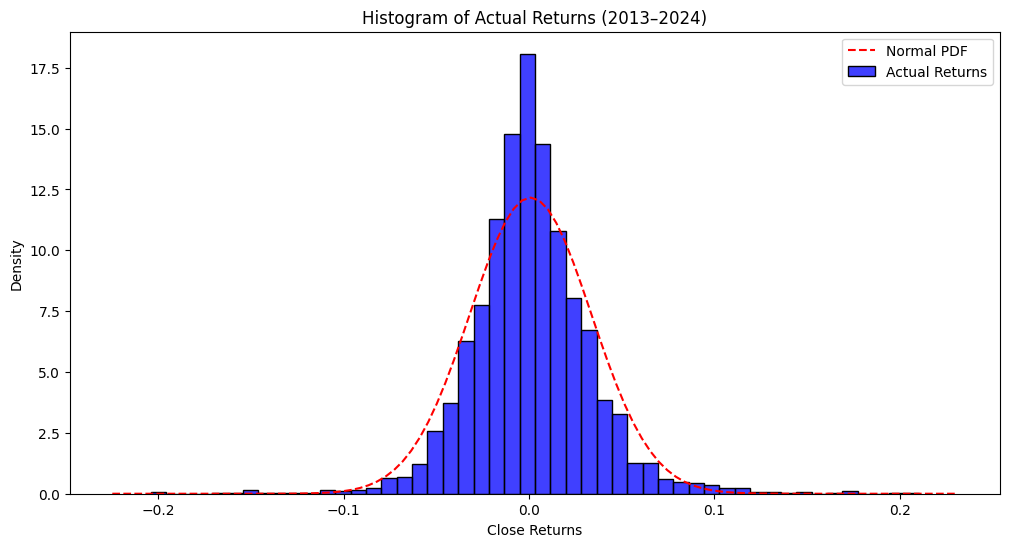

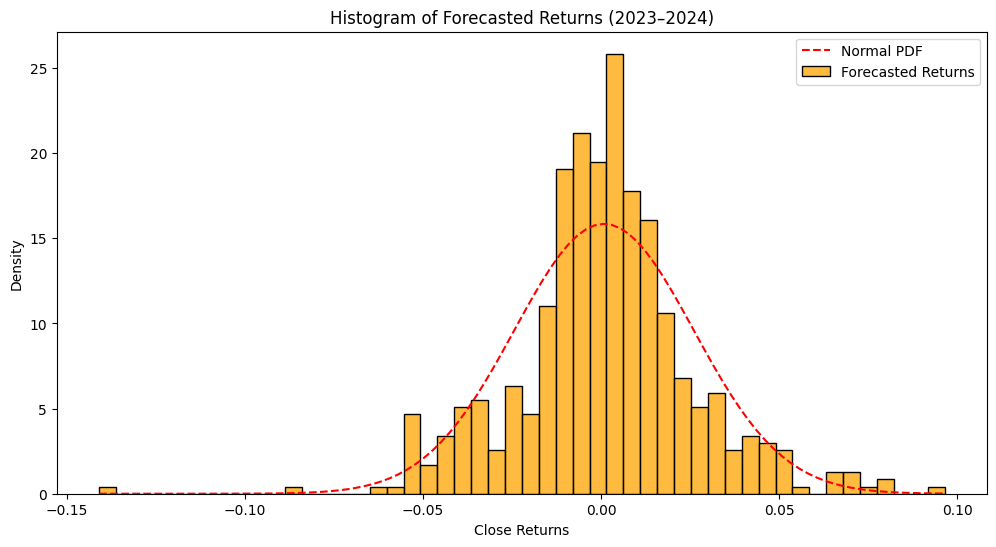

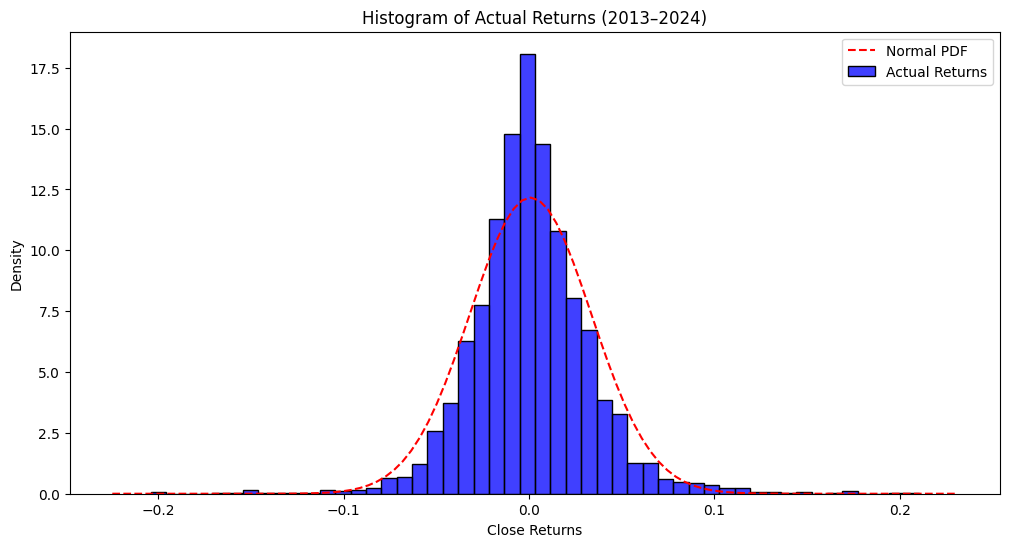

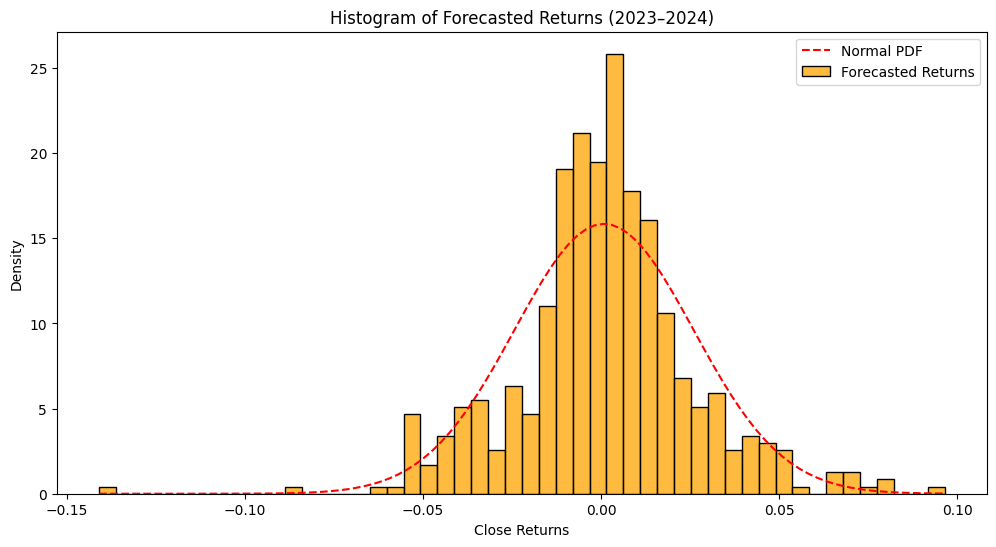

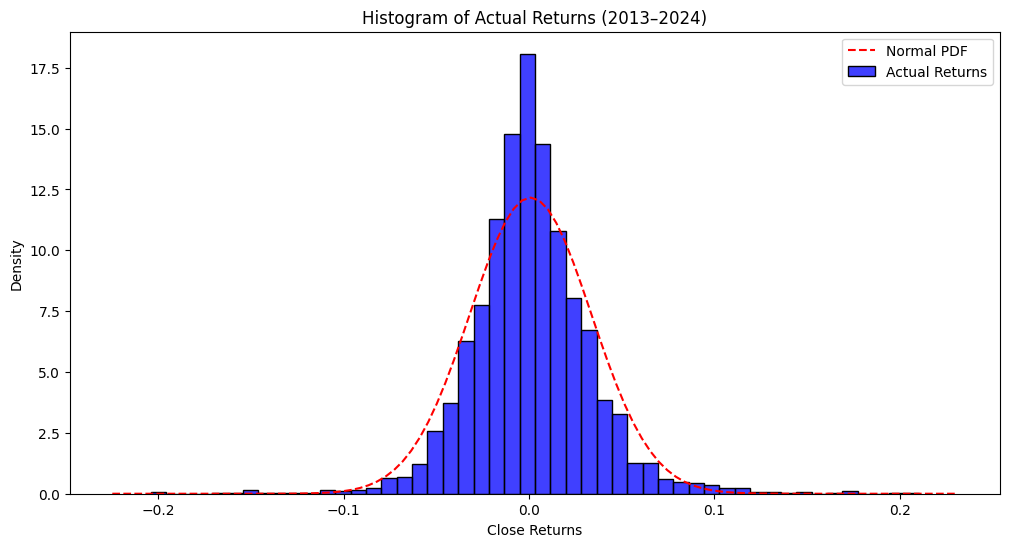

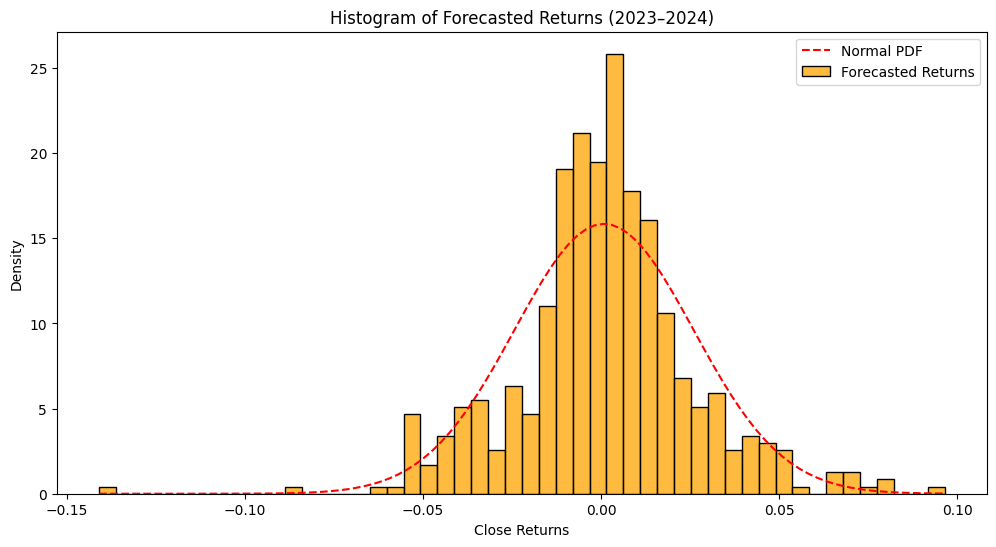

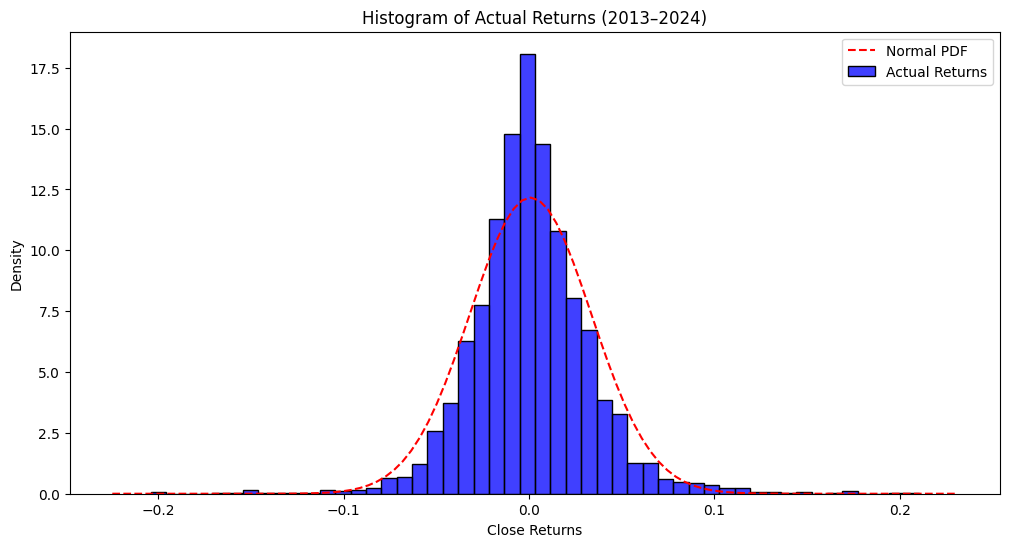

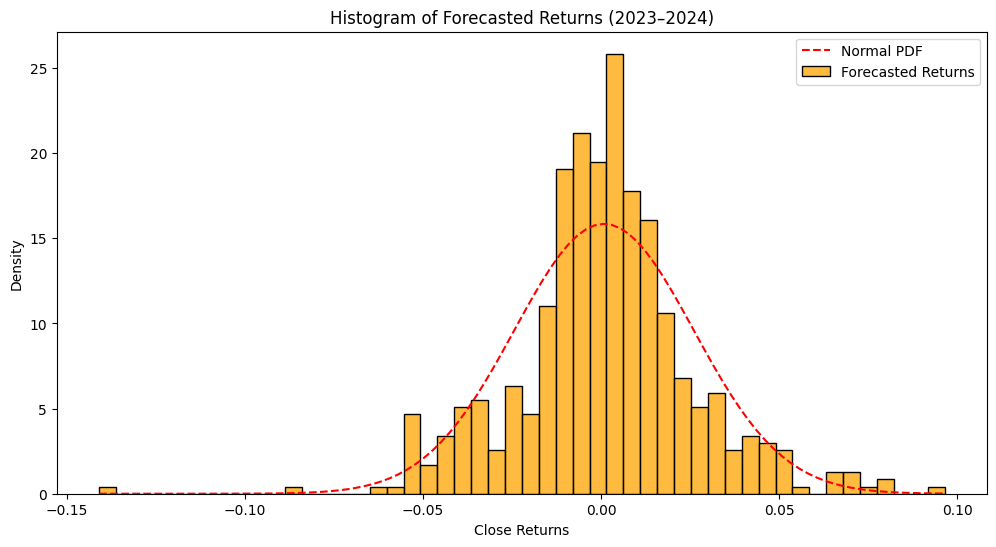

In [52]:
#KNN
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
# ==============================
# Histogram of ACTUAL returns (2013–2024)
# ==============================
plt.figure(figsize=(12,6))
sns.histplot(data_returns["Close"], bins=50, kde=False, color="blue", stat="density", label="Actual Returns")

# Fit and plot normal PDF
mu, std = stats.norm.fit(data_returns["Close"].dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Actual Returns (2013–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

# ==============================
# Histogram of FORECASTED returns (2023–2024)
# ==============================
plt.figure(figsize=(12,6))
sns.histplot(y_pred, bins=50, kde=False, color="orange", stat="density", label="Forecasted Returns")

# Fit and plot normal PDF
mu, std = stats.norm.fit(y_pred)
x = np.linspace(min(y_pred), max(y_pred), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Forecasted Returns (2023–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

#SVR
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# ==============================
# Histogram of ACTUAL returns (2013–2024)
# ==============================
plt.figure(figsize=(12,6))
sns.histplot(data_returns["Close"], bins=50, kde=False, color="blue", stat="density", label="Actual Returns")

# Fit and plot normal PDF
mu, std = stats.norm.fit(data_returns["Close"].dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Actual Returns (2013–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

# ==============================
# Histogram of FORECASTED returns (2023–2024)
# ==============================
plt.figure(figsize=(12,6))
sns.histplot(y_pred, bins=50, kde=False, color="orange", stat="density", label="Forecasted Returns")

# Fit and plot normal PDF
mu, std = stats.norm.fit(y_pred)
x = np.linspace(min(y_pred), max(y_pred), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Forecasted Returns (2023–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

#RF
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

plt.figure(figsize=(12,6))
sns.histplot(data_returns["Close"], bins=50, kde=False, color="blue", stat="density", label="Actual Returns")

mu, std = stats.norm.fit(data_returns["Close"].dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Actual Returns (2013–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(y_pred, bins=50, kde=False, color="orange", stat="density", label="Forecasted Returns")

mu, std = stats.norm.fit(y_pred)
x = np.linspace(min(y_pred), max(y_pred), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Forecasted Returns (2023–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

#XGBOOST

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
# ==============================
# Histogram of ACTUAL returns (2013–2024)
# ==============================
plt.figure(figsize=(12,6))
sns.histplot(data_returns["Close"], bins=50, kde=False, color="blue", stat="density", label="Actual Returns")

# Fit and plot normal PDF
mu, std = stats.norm.fit(data_returns["Close"].dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Actual Returns (2013–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

# ==============================
# Histogram of FORECASTED returns (2023–2024)
# ==============================
plt.figure(figsize=(12,6))
sns.histplot(y_pred, bins=50, kde=False, color="orange", stat="density", label="Forecasted Returns")

# Fit and plot normal PDF
mu, std = stats.norm.fit(y_pred)
x = np.linspace(min(y_pred), max(y_pred), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Forecasted Returns (2023–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()
